<h1>Plot Luquillo CZO discharge data and USGS discharge data</h1>
<p>1) First load standard python libraries</p>

In [1]:
%matplotlib inline

import sys
import os
from datetime import datetime
import pprint
import numpy as np
import getpass
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from IPython.display import display, HTML
import ipywidgets as widgets
from utilities import hydroshare
from odm2api.ODM2.services.readService import *
from odm2api.ODM2.services.createService import *
import ulmo
import json
from ulmo.usgs import nwis
import warnings 
warnings.filterwarnings('ignore')

/opt/conda/envs/python2/lib/python2.7/site-packages/ulmo/twc/kbdi/core.py:20: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  CSV_SWITCHOVER = pandas.tslib.Timestamp('2016-10-01')


<p>2) Next load odm2api components we will use </p>

In [2]:
from odm2api.ODMconnection import dbconnection
import odm2api.ODM2.services.readService as odm2
from odm2api.ODM2.models import *

<p>3) now connect to the database and instantiate the read service </p>

In [3]:
#session_factory = dbconnection.createConnection('postgresql', database_address_text.value, database_text.value, 
#                                                username_text.value, p) 
#read = odm2.ReadODM2(session_factory)

# get resource content.  Returns a dictionary of filenames and their paths 
hs = hydroshare.hydroshare()
content = hs.getResourceFromHydroShare('e049f19dc8ba46c98754711da2ab6030')

LCZOSensorDB = hs.content['LCZO-ODM2-MariaTimeSeries.sqlite']

session_factory = dbconnection.createConnection('sqlite', LCZOSensorDB)
read = ReadODM2(session_factory)
write = CreateODM2(session_factory)

Adding the following system variables:
   HS_USR_NAME = miguelcleon
   HS_RES_ID = a5669d17013445c896a8397a8e22ece3
   HS_RES_TYPE = timeseriesresource
   JUPYTER_HUB_IP = jupyter.cuahsi.org

These can be accessed using the following command: 
   os.environ[key]

   (e.g.)
   os.environ["HS_USR_NAME"]  => miguelcleon

The hs_utils library requires a secure connection to your HydroShare account.
Enter the HydroShare password for user 'miguelcleon': ········
Successfully established a connection with HydroShare
This resource already exists in your userspace.
Would you like to overwrite this data [Y/n]? n



<h3>Retrieve USGS data </h3>
<p>4) use ulmo to connect to USGS data. </p>

<p>5) setup a pandas dataframe and show some basic statistics about it.</p>

In [6]:
# nwis.hdf5.update_site_data('50067000',start='2017-09-01', end='2017-09-30')#   12189500

# read daily mean discharge data from cache (statistics code 00003)
#Rio Sabana
data = nwis.get_site_data('50067000',start='2017-09-01', end='2017-09-30') #, parameter_code='00060:00003')['00060:00003']

# print(data['value'])
#for vals in data['values']:
#    print(vals['value'] + ' ' + vals['datetime'])
#for keys,values in data.items():
#    print(keys)
#    print(values)

sabanaDf = pd.DataFrame(data['00060:00000']['values']).drop(['qualifiers'], axis=1).set_index('datetime')
sabanaDf.value = sabanaDf.value.apply(np.float)
sabanaDf.index = pd.to_datetime(sabanaDf.index).to_period('min')
# sabanaDf['datetime'] = pd.Series(pd.to_datetime(data['00060:00000']['datetime']).to_period('min'), index = sabanaDf.index)
#  Series(np.random.randn(sLength), index=df1.index)


# mark bad data as NaN
sabanaDf[sabanaDf.values == -999999] = np.nan
print(sabanaDf.describe())


processing data from request: https://waterservices.usgs.gov/nwis/dv/?endDT=2017-09-30&startDT=2017-09-01&site=50067000&format=waterml
processing data from request: https://nwis.waterservices.usgs.gov/nwis/iv/?endDT=2017-09-30T00%3A00%3A00&startDT=2017-09-01T00%3A00%3A00&site=50067000&format=waterml


             value
count  2403.000000
mean     73.890354
std     335.053196
min       9.220000
25%      12.900000
50%      14.400000
75%      20.800000
max    4700.000000


<h3>Retrieve LCZO Data </h3>
<p>6) Retrieve LCZO Discharge data from SQLite file we have loaded in the local environment. These data are for the Quebrada Sonadora a discontinued USGS gage the LCZO is now mangaing.</p>
<p>7) Show basic statistics about the LCZO discharge data. </p> 

In [9]:
# print(resultWidget.value)
# print(resultWidget2.value)
resultids = []
resultnames = {}
selectedResult = read.getDetailedResultInfo(resultTypeCV = 'Time series coverage',resultID=17274)
resultidlist = list()
resultidlist.append(17274)
DischargeResultValues = read.getResultValues(resultids=resultidlist, starttime='2017-09-01', 
                                                 endtime= '2017-09-30')
print(DischargeResultValues['datavalue'].describe())

# get second time series 




count    2780.000000
mean       22.126960
std        44.040375
min         7.430561
25%         9.092660
50%        11.239964
75%        16.278315
max       787.825819
Name: datavalue, dtype: float64


<p>8) Format a plot and plot the selected time series</p>

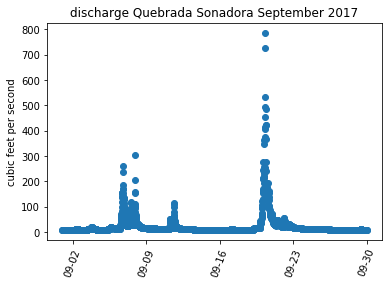

In [10]:
dateFmt = DateFormatter('%m-%d')
fig, ax = plt.subplots()
# pprint.pprint(BaroPressureResultValues.__dict__)
ax.plot_date(DischargeResultValues['valuedatetime'], DischargeResultValues['datavalue'])
ax.xaxis.set_major_formatter(dateFmt)
plt.xticks(rotation=70)
for result in selectedResult:
    plt.title(str(result.VariableCode) + ' Quebrada Sonadora September 2017')
    plt.ylabel(result.UnitsName)

    
    
#time_format = '%Y-%m-%d %H:%M'

#time = [datetime.strptime(i, ti#me_format) for i in sabanaDf.index.to_series().astype(str)]
# print(time)
#ax.plot_date(time, sabanaDf['value'])
#ax.xaxis.set_major_formatter(dateFmt)
#plt.xticks(rotation=70)
#for result in selectedResult2:
#    plt.title(str(result.VariableCode) + ' September 2017')
#    plt.ylabel(result.UnitsName)
    
# QS = 375 meters RI = 618 meters elevation 

<p>9) Use the numpy libaray to calculate some statistics about the time series</p> 
<p>10) Dynamically create histogram bins based on the time series standard deviation and graph the histogram</p>

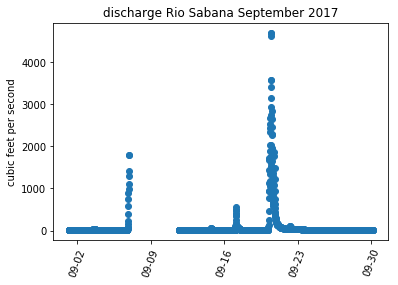

In [11]:
dateFmt = DateFormatter('%m-%d')
fig, ax = plt.subplots()
# pprint.pprint(BaroPressureResultValues.__dict__)
time_format = '%Y-%m-%d %H:%M'

time = [datetime.strptime(i, time_format) for i in sabanaDf.index.to_series().astype(str)]
# print(time)
ax.plot_date(time, sabanaDf['value'])
ax.xaxis.set_major_formatter(dateFmt)
plt.xticks(rotation=70)
for result in selectedResult:
    plt.title(str(result.VariableCode) + ' Rio Sabana September 2017')
    plt.ylabel(result.UnitsName)
    
# QS = 375 meters RI = 618 meters elevation 